In [1]:
%load_ext autoreload
%autoreload
from inspect import getmembers, isfunction
from hlee_notClass_multiplexed_lee22e import *
from hlee_utils import *
from icecream import ic

# Algorithms for Parallel MultConv should come first.

# 1. MultParPack()
- pi-copies of MultPack(A) fill a single ciphertext. 

In [2]:
##################################
#          MultParPack()         #
##################################

def MultParPack(A,dims=[],nslots=2**15):
    ha,wa,ca,ka,ta,pa = dims[0],dims[1],dims[2],dims[3],dims[4],dims[5]
    A_mp = MultPack(A,ins)
    out = np.zeros(nslots)
    for i in range(0,pa):
        rot =-i*int(np.round((nslots/pa)))
        out = out+ np.roll(A_mp,rot)
    return out

# 2. MultParWgt()
<span style="color:red">- MultConv에서 쓰던 MultWgt()</br>
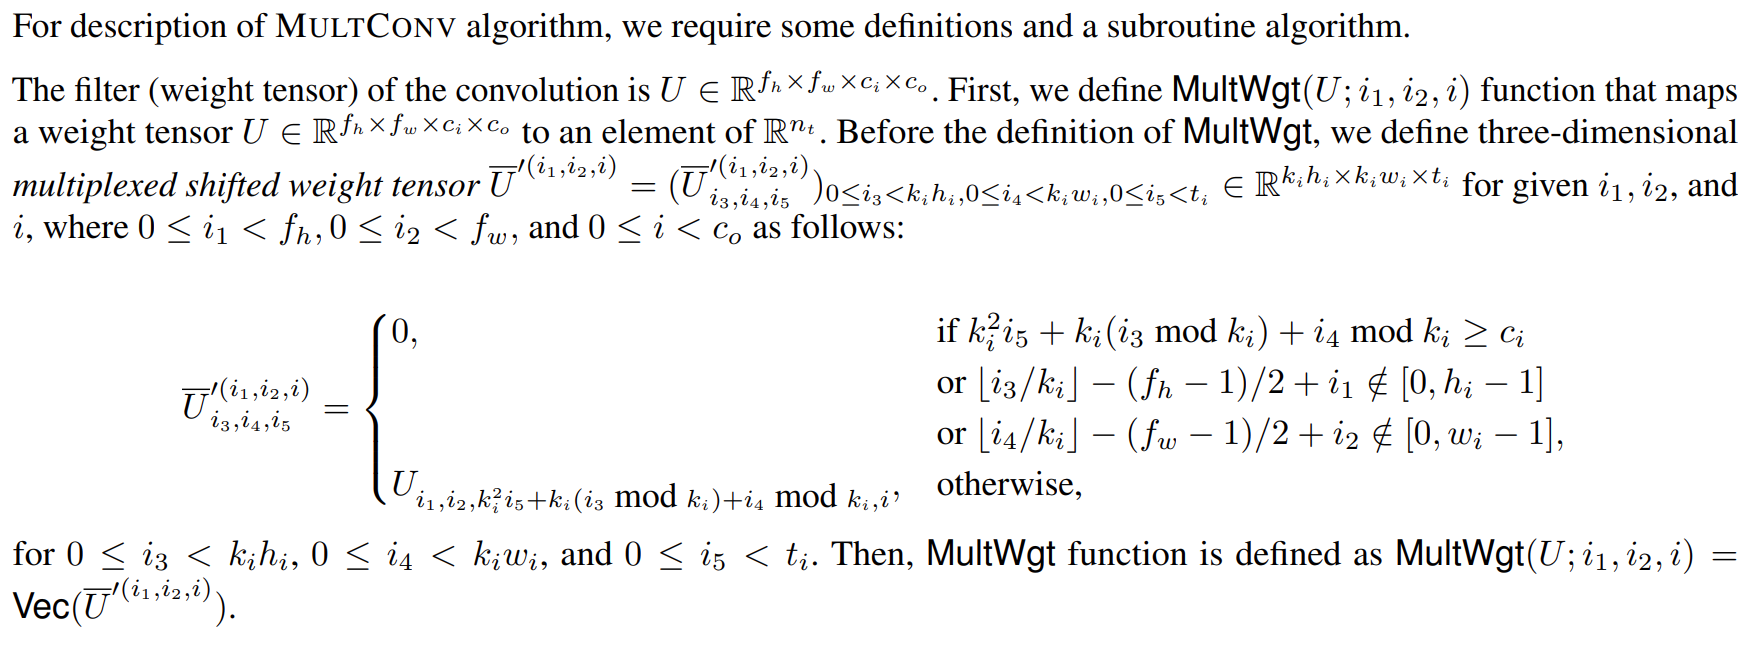
<span style="color:red">- ParMultConv에서 달라진 점</br>
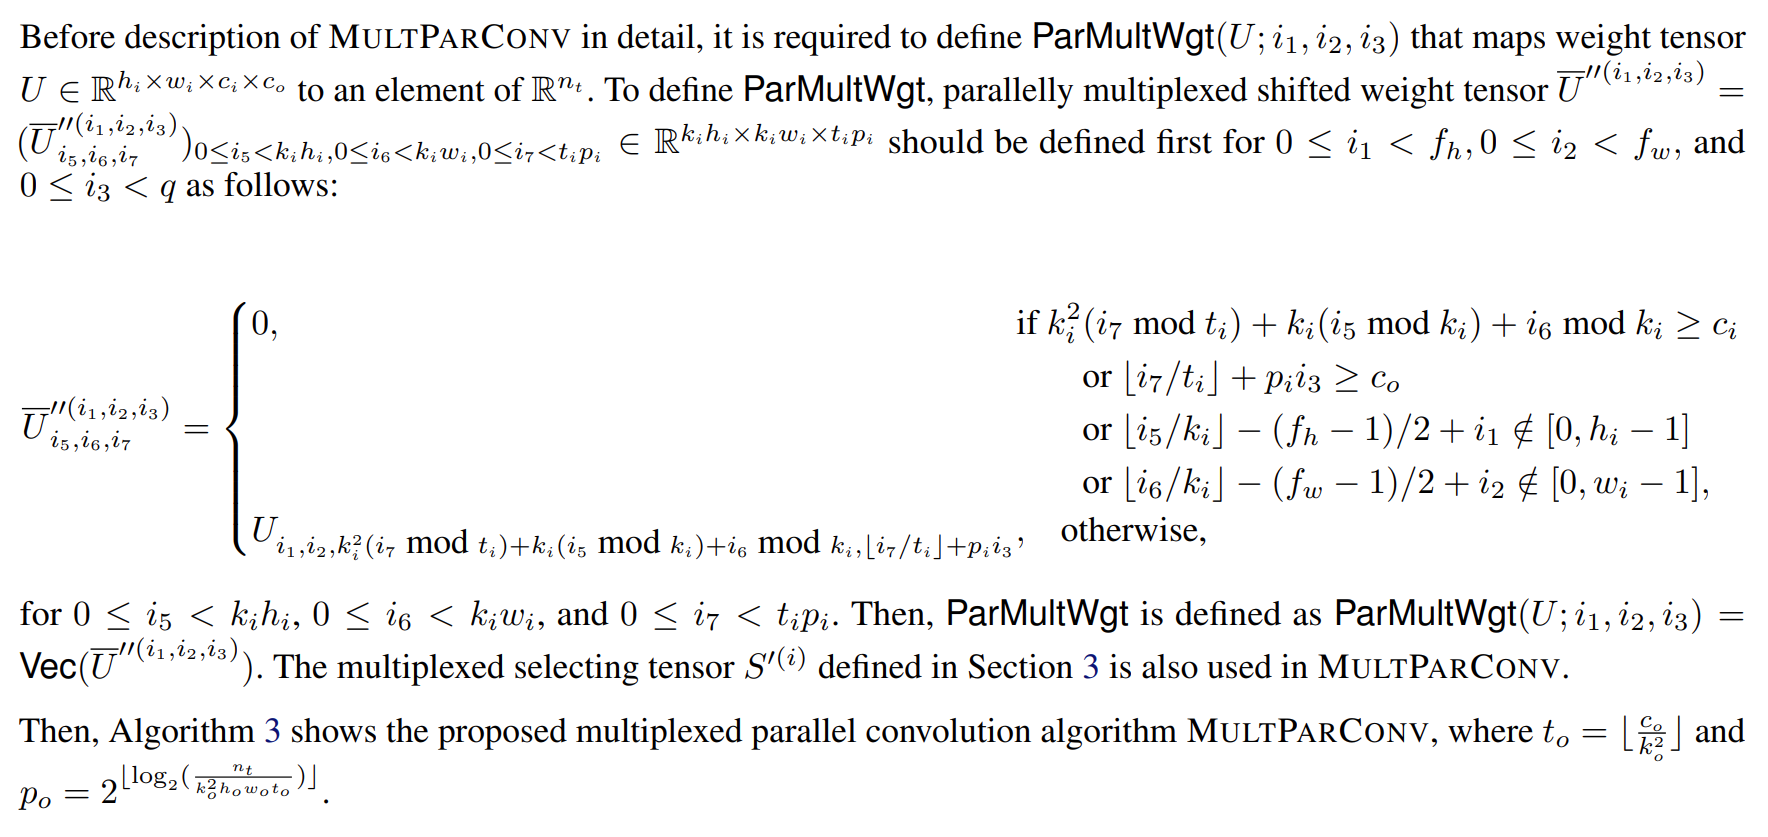

In [3]:
##################################
#          ParMultWgt()          #
##################################

def tensor_multiplexed_shifted_weight_par(U,i1,i2,i3,ins=[]):
    fh,fw= 3,3
    hi,wi,ci,ki,ti,pi = ins[0],ins[1],ins[2],ins[3],ins[4],ins[5]
    q = get_q(co,pi)   
    #print(ins,q)
    out = np.zeros([hi*ki, wi*ki,ti*pi])
    for i5 in range(hi*ki):
        for i6 in range(wi*ki):
            for i7 in range(ti*pi):
                cond0 = np.floor(i7/ti)+pi*i3
                cond1 = ki**2*(i7%ti) + ki*(i5%ki) + (i6%ki)
                cond2 = np.floor(i5/ki)-(fh-1)/2+i1
                cond3 = np.floor(i6/ki)-(fw-1)/2+i2
                if (cond0 >= co or cond1 >= ci or 
                    cond2 not in range(hi) or cond3 not in range(wi)):
                    out[i5][i6][i7] = 0
                else:
                    idx_3rd = ki**2*(i7%ti)+ki*(i5%ki)+i6%ki
                    idx_4th = int(np.floor(i7/ti)+pi*i3)
                    out[i5][i6][i7] = U[i1][i2][idx_3rd][idx_4th]
                #if out[i5][i6][i7]!=0:
                #    print(f"------------------------NOTZERO {i5},{i6},{i7}")
    return out

def ParMultWgt(U,i1,i2,i3,ins=[],nslots=2**15):
    out = np.zeros(nslots)
    temp = Vec(tensor_multiplexed_shifted_weight_par(U,i1,i2,i3,ins))
    out[:temp.size]=temp
    #print(f"-------------------------------{temp.size}")
    return out

# 3. MultParConv()

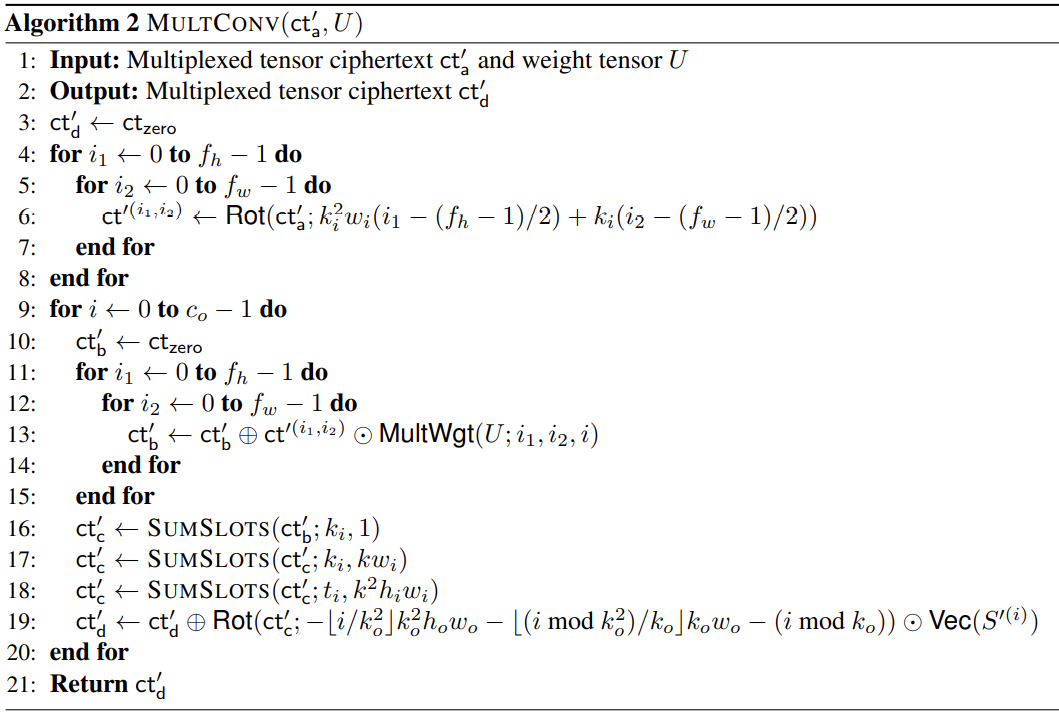

In [80]:
##################################
#          MulParConv()          #
##################################

def MultParConv(ct_a,U,ins=[],outs=[],kernels=[3,3],nslots=2**15):
    hi,wi,ci,ki,ti,pi = ins[0],ins[1],ins[2],ins[3],ins[4],ins[5]
    ho,wo,co,ko,to,po = outs[0],outs[1],outs[2],outs[3],outs[4],outs[5]
    q = get_q(co,pi)
    fh,fw= kernels[0],kernels[1]
    print(f"[MultParConv] (hi,wi,ci,ki,ti,pi) =({hi:2},{wi:2},{ci:2},{ki:2},{ti:2},{pi:2})")
    print(f"[MultParConv] (ho,wo,co,ko,to,po) =({ho:2},{wo:2},{co:2},{ko:2},{to:2},{po:2})")
    print(f"[MultParConv] q = {q}")
    
    ct_d = np.zeros(nslots)
    ct = []
    nrots=0
    for i1 in range(fh):
        temp = []
        for i2 in range(fw):
            lrots = int((-(ki**2)*wi*(i1-(fh-1)/2) - ki*(i2-(fw-1)/2))) #both neg in the paper, git -,+
            temp.append(np.roll(ct_a,lrots))
            if lrots!=0:
                nrots = nrots+ 1#____________________________________ROTATION
        ct.append(temp)
    for i3 in range(q):
        ct_b = np.zeros(nslots)
        for i1 in range(fh):
            for i2 in range(fw):
                ct_b = ct_b + ct[i1][i2]*ParMultWgt(U,i1,i2,i3,ins,nslots)
        ct_c = SumSlots(ct_b, ki,              1 )
        ct_c = SumSlots(ct_c, ki,          ki*wi )
        ct_c = SumSlots(ct_c, ti, (ki**2)*hi*wi)
        #-----diff
        for i4 in range(0,min(pi,co-pi*i3)):
            i = pi*i3 +i4
            S_mp = tensor_multiplexed_selecting(ho,wo,co,ko,to,i)
            vec_S = Vec(S_mp)
            r0 = int(np.floor(nslots/pi))*(i%pi)
            r1 = int(np.floor(i/(ko**2)))*ko**2*ho*wo
            r2 = int(np.floor((i%(ko**2))/ko))*ko*wo
            r3 = i%ko
            rrots = +r0-r1-r2-r3
            rolled =  np.roll(ct_c, -rrots)
            ct_d = ct_d +rolled*vec_S
            if rrots!=0:
                nrots=nrots+1 #_________________________________________ROTATION
    for j in range(int(np.round(np.log2(po)))):
        r = int(np.round(2**j*(nslots/po)))
        ct_d = ct_d + np.roll(ct_d,-r)
    return ct_d


[MultParConv] (hi,wi,ci,ki,ti,pi) =(32,32, 4, 2, 1, 8)
[MultParConv] (ho,wo,co,ko,to,po) =(32,32, 4, 2, 1, 8)
[MultParConv] q = 1


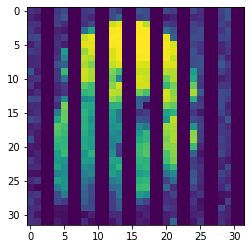

In [81]:
hi,wi,ci,ki,ti = 32,32,4,2,1
ho,wo,co,ko,to = 32,32,4,2,1
#############################
#  Dimensions, Params       #
#############################
nslots = 2**15
pi = get_p(nslots,hi,wi,ki,ti)
po = get_p(nslots,ho,wo,ko,to)
ins =  [hi,wi,ci,ki,ti,pi]
outs = [ho,wo,co,ko,to,po]
fh,fw = 3,3
img = cv2.imread("cute.jpg")
img = cv2.resize(img,(32,32))

temp = list(get_channel_first(img))
temp.append(np.zeros([32,32]))
img = get_channel_last(np.array(temp))
#############################
#  kernels that do nothing  #
############################
U = np.zeros([fh,fw,ci,co])
for l in range(co):
    for k in range(ci):
        for i in range(fh):
            for j in range(fw):
                if i==1 and j==1:
                    U[i,j,k,l]=1
                
#U = get_channel_last(U)
U_ch1st = get_channel_first(U)
#############################################################
ct_a = MultParPack(img,ins)
out = MultParConv(ct_a,U,ins,outs)
un = unpack(out,outs)
plt.imshow(un[0])

ic| len(temp): 3
ic| np.array(temp).shape: (3, 64, 64)
ic| U.shape: (3, 3, 3, 4)


[MultParConv] (hi,wi,ci,ki,ti,pi) =(64,64, 3, 2, 1, 2)
[MultParConv] (ho,wo,co,ko,to,po) =(64,64, 4, 2, 1, 2)
[MultParConv] q = 2


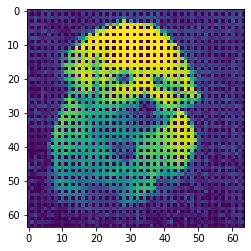

In [145]:
hi,wi,ci,ki,ti = 64,64,3,2,1
ho,wo,co,ko,to = 64,64,4,2,1
#############################
#  Dimensions, Params       #
#############################
nslots = 2**15
pi = get_p(nslots,hi,wi,ki,ti)
po = get_p(nslots,ho,wo,ko,to)
ins =  [hi,wi,ci,ki,ti,pi]
outs = [ho,wo,co,ko,to,po]
fh,fw = 3,3
#img = cv2.imread("pyramid2.png")
img = cv2.imread("cute.jpg")
img = cv2.resize(img,(hi,wi))

temp = list(get_channel_first(img))
ic(len(temp))
while(1):
    if len(temp)>=ci:
        break
    temp.append(np.ones([hi,wi]))
        
ic(np.array(temp).shape)
img = get_channel_last(np.array(temp))
#img = np.zeros([hi,wi,ci])
#for i in range(hi):
#    for j in range(wi):
#        for k in range(ci):
#            img[i,j,k] = 100*(i+1)+10*(j+1)+(k+1)

#############################
#  kernels that do nothing  #
############################
U = np.zeros([fh,fw,ci,co])
for l in range(co):
    for k in range(ci):
        for i in range(fh):
            for j in range(fw):
                if i==1 and j==1:
                    U[i,j,k,l]=1
                
#U = get_channel_last(U)
U_ch1st = get_channel_first(U)
ic(U.shape)
#############################################################
ct_a = MultParPack(img,ins)
out = MultParConv(ct_a,U,ins,outs)
un = unpack(out,outs)

plt.imshow((un[0][:int(ho/to)])[:,:int(wo/to)])
plt.imshow(un[0])

ic| len(temp): 3
ic| np.array(temp).shape: (3, 64, 64)
ic| U.shape: (3, 3, 3, 4)


[MultParConv] (hi,wi,ci,ki,ti,pi) =(64,64, 3, 1, 3, 2)
[MultParConv] (ho,wo,co,ko,to,po) =(64,64, 4, 1, 4, 2)
[MultParConv] q = 2


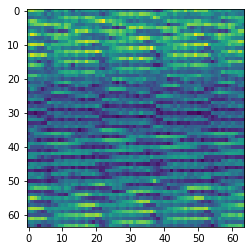

In [130]:
hi,wi,ci,ki,ti = 64,64,3,1,3
ho,wo,co,ko,to = 64,64,4,1,4
#############################
#  Dimensions, Params       #
#############################
nslots = 2**15
pi = get_p(nslots,hi,wi,ki,ti)
po = get_p(nslots,ho,wo,ko,to)
ins =  [hi,wi,ci,ki,ti,pi]
outs = [ho,wo,co,ko,to,po]
fh,fw = 3,3
#img = cv2.imread("pyramid2.png")
img = cv2.imread("cute.jpg")
img = cv2.resize(img,(hi,wi))

temp = list(get_channel_first(img))
ic(len(temp))
while(1):
    if len(temp)>=ci:
        break
    temp.append(np.ones([hi,wi]))
        
ic(np.array(temp).shape)
img = get_channel_last(np.array(temp))
#img = np.zeros([hi,wi,ci])
#for i in range(hi):
#    for j in range(wi):
#        for k in range(ci):
#            img[i,j,k] = 100*(i+1)+10*(j+1)+(k+1)

#############################
#  kernels that do nothing  #
############################
U = np.zeros([fh,fw,ci,co])
for l in range(co):
    for k in range(ci):
        for i in range(fh):
            for j in range(fw):
                if i==1 and j==1:
                    U[i,j,k,l]=1
                
#U = get_channel_last(U)
U_ch1st = get_channel_first(U)
ic(U.shape)
#############################################################
ct_a = MultParPack(img,ins)
out = MultParConv(ct_a,U,ins,outs)
un = unpack(out,outs)

plt.imshow((un[0][:int(ho/ko)])[:,:int(wo/ko)])
plt.imshow(un[0])

# test if unpack() needs for changes

4


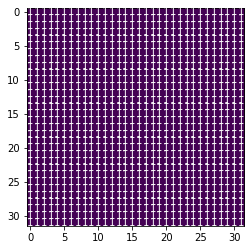

In [211]:
s = np.zeros([32,32,8])
for i in range(32):
    for j in range(32):
        for k in range(8):
            s[i,j,k]=(k+1)
imshow_with_value(get_channel_first(s)[0],0)

print(p)
h,w,c,k,t = 32,32,8,2,2
dims = [h,w,c,k,t,get_p(nslots,h,w,k,t)]
m = MultParPack(s,dims,nslots)

In [201]:
def unpack(ct,dims=[]):
    fh,fw= 3,3
    ha,wa,ca,ka,ta,pa = dims[0],dims[1],dims[2],dims[3],dims[4],dims[5]
    tsize = ha*wa*ka**2
    ch  = []
    for channel in range(ka**2*ta):
        r = channel%(ka**2)
        idx_start_channel = ta*(r%ka)+int(np.floor(r/ka))*ta*ka*wa +int(np.floor(channel/(ka**2)))
        mat=[]
        for i in range(ha):
            row = []
            for j in range(wa):
                idx = idx_start_channel+i*wa*ta*ka**2+j*ka*ta
                row.append(ct[idx])
            mat.append(row)
        ch.append(mat)
    return np.array(ch)

### ----> unpack() 예상대로 결과unpack잘 됨.